In [1]:
import PAA_LISA
import NOISE_LISA
import os

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from fractions import Fraction
import math
import datetime
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')
#warnings.filterwarnings("error")
import scipy.optimize

year2sec=32536000
day2sec=year2sec/365.25
c=300000000

In [2]:
input_param = {
        'calc_method': 'Waluschka',
        'plot_on':False, #If plots will be made
        'dir_savefig': os.getcwd(), # The directory where the figures will be saved. If False, it will be in the current working directory
        'noise_check':False,
        'home':'/home/ester/git/synthlisa/', # Home directory
        'directory_imp': False,
        'num_back': 0,
        'dir_orbits': '/home/ester/git/synthlisa/orbits/', # Folder with orbit files
        'length_calc': 20, # Length of number of imported datapoints of orbit files. 'all' is also possible
        'dir_extr': 'zzzWaluschka_no_abberation', # This will be added to the folder name of the figures
        'timeunit':'Default', # The timeunit of the plots (['minutes'],['days']['years'])
        'LISA_opt':True, # If a LISA object from syntheticLISA will be used for further calculations (not sure if it works properly if this False)
        'arm_influence': True, # Set True to consider the travel time of the photons when calculating the nominal armlengths
        'tstep':False,
        'delay':True, #'Not ahead' or False
        'method':'fsolve', # Method used to solve the equation for the photon traveling time
        'valorfunc':'Function', #
        'select':'Hallion', # Select which orbit files will be imported ('all' is all)
        'test_calc':False,
        'abberation':False,
        'delay': True
        }

data_all = PAA_LISA.runfile.do_run(input_param)

['positions_timestep_days_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_10.txt', 'readable.py', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
['McKenzie_orbit_timestep_seconds_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000.txt']
['Folkner_orbit_timestep_seconds_scale_10.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Dir_extr:zzzWaluschka_no_abberation
Getting scale by filename:
1000.0

Getting timestep by filename:
days

Waluschka

Importing Orbit
20 datapoints
Done in 0.03326
Selected calculation method is: Waluschka

Selected calculation method is: Waluschka

Selected calculation method is: Waluschka

A

In [3]:
for k in range(0,len(data_all)/2):
    #data = PAA_res[str(k+1)]
    data = data_all[str(k+1)]
t_vec = data.t_all

In [4]:
Ndata = NOISE_LISA.Noise(data=data)

Obtaining noise
Obaining lasernoise
Obtaining shotnoise


In [5]:
Ndata.PAA_point

<bound method Noise.PAA_point of <NOISE_LISA.calc.Noise instance at 0x7f634bfb2320>>

In [6]:
wfe = NOISE_LISA.WFE(Ndata=Ndata)

In [7]:
wfe.tele_control='full control'
wfe.pupil(Nbins=20)
wfe.side = 'r'
wfe.scale = 1#1e-9 # Scales distance of SC

wfe.speed_on = True # Makes calculation faster, only valid for long armlengths
wfe.simple = True # Calculates only 1 pixel

In [8]:
wfe.tele_control_ss(step_max=4,dt = 3600)

0

In [9]:
i=1
t = t_vec[2]
wfe.simple=False
wfe.jitter=[False,False]

In [10]:
labda = wfe.Ndata.data.labda
w0 = wfe.Ndata.data.w0
E0 = 1 #...adjust
k = (2*np.pi)/labda
D = wfe.Ndata.data.D
LA = PAA_LISA.utils.la()
L_tele = 2 # length telescope

In [11]:
wfe.do_ttl_send()

0

In [12]:
wfe.Ndata.PAA_point()

0

In [13]:
wfe.scan_tele()

0

6.54684727209085e-07

In [53]:
scan_wf = []
ang_SS = []
PAA_ang = []
i = 1
[i_self,i_left,i_right] = PAA_LISA.utils.i_slr(i_self)
t_plot = np.linspace(t_vec[1],t_vec[4],100)
for t in t_plot:
    tdel = wfe.Ndata.data.L_rl_func_tot(i,t)
    scan_wf.append(wfe.wf_scan_l(i,t))
    ang_SS.append(wfe.tele_SS_l(i,t))
    PAA_ang.append(LA.angle(wfe.Ndata.PAA_point_r(i_left,t-tdel),wfe.Ndata.data.v_r_func_tot(i_left,t-tdel)))

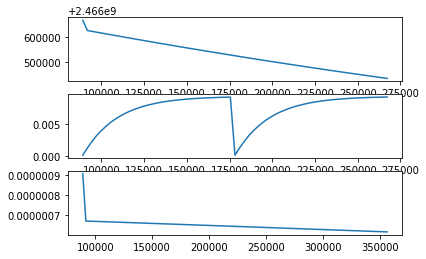

In [54]:
f,ax = plt.subplots(3,1)
ax[0].plot(t_plot,scan_wf)
ax[1].plot(t_plot,ang_SS)
ax[2].plot(t_plot,PAA_ang)


In [81]:
# ploting
ang_opt = []
ang_SS = []
ang_nc = []
for t in t_plot:
    r = wfe.Ndata.data.r_func(i,t)
    ang_opt.append(LA.angle(wfe.Ndata.tele_l_fc(i,t),r))
    ang_nc.append(LA.angle(wfe.Ndata.tele_l(i,t),r))
    ang_SS.append(wfe.tele_SS_l(i,t)+ang_nc[-1])

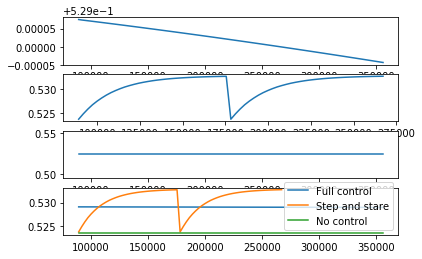

In [82]:
f,ax = plt.subplots(4,1)
ax[0].plot(t_plot,ang_opt,label = 'Full control')
ax[1].plot(t_plot,ang_SS,label='Step and stare')
ax[2].plot(t_plot,ang_nc,label='No control')
ax[3].plot(t_plot,ang_opt,label = 'Full control')
ax[3].plot(t_plot,ang_SS,label='Step and stare')
ax[3].plot(t_plot,ang_nc,label='No control')
ax[3].legend(loc='best')

In [77]:
wfe.Ndata.data.v_l_func_tot(1,12321)

array([-1.50165186e+09,  9.79988679e+08, -1.82428586e+09])

In [80]:
wfe.Ndata.data.t_all

array([      0.        ,   89078.71321013,  178157.42642026,
        267236.13963039,  356314.85284052,  445393.56605065,
        534472.27926078,  623550.99247091,  712629.70568104,
        801708.41889117,  890787.1321013 ,  979865.84531143,
       1068944.55852156, 1158023.27173169, 1247101.98494182,
       1336180.69815195, 1425259.41136208, 1514338.12457221,
       1603416.83778234, 1692495.55099247])

In [15]:
i_self = 1
t = t_vec[2]
side='l'
self=wfe

In [16]:
[i_self,i_left,i_right] = PAA_LISA.utils.i_slr(i_self)
n = Ndata.data.n_func(i_self,t)
    
if side=='l':
    i_next = i_left
    tdel = self.Ndata.data.L_rl_func_tot(i_self,t)
    n_left = Ndata.data.n_func(i_left,t-tdel)
    if self.tele_control=='full control':
        tele_rec = Ndata.tele_l_fc(i_self,t)
        tele_send = Ndata.tele_r_fc(i_left,tdel)
    elif self.tele_control=='no control':
        tele_rec = Ndata.tele_l(i_self,t)
        tele_send = Ndata.tele_r(i_left,t-tdel)
    elif self.tele_control=='SS':
        r = Ndata.data.r_func(i_self,t)
        ang_SS = self.tele_SS_l(i_self,t)
        ang_SS_left = self.tele_SS_r(i_left,t-tdel)
        tele_rec = LA.unit(LA.rotate(Ndata.tele_l(i_self,t),n,ang_SS))
        tele_send = LA.unit(LA.rotate(Ndata.tele_r(i_left,t-tdel),n_left,ang_SS_left))

    n_beam = self.Ndata.data.n_func(i_left,(t-tdel))
    beam = self.Ndata.PAA_point_r(i_left,t-tdel)#...adjust for sending telescope --> PAAM control
    v_pos = self.Ndata.data.v_r_func_tot(i_left,t-tdel)
    ps_send = self.phasefront_send(i_self,t,side='l')
        
elif side=='r':
    i_next = i_right
    tdel = self.Ndata.data.L_rr_func_tot(i,t)
    if self.tele_control=='full control':
        tele_rec = Ndata.tele_r_fc(i_self,t)
        tele_send = Ndata.tele_l_fc(i_right,t-tdel)
    elif self.tele_control=='no control':
        tele_rec = Ndata.tele_r(i_self,t)
        tele_send = Ndata.tele_l(i_right,t-tdel)
    elif self.tele_control=='SS':
        r = Ndata.data.r_func(i_self,t)
        ang_SS = self.tele_SS_r(i_self,t)
        ang_SS_right = self.tele_SS_l(i_right,t-tdel)

        tele_rec = LA.unit(LA.rotate(Ndata.tele_r(i_self,t),n,ang_SS))
        tele_send = LA.unit(LA.rotate(Ndata.tele_l(i_right,t-tdel),n_right,ang_SS_right))
    
    n_beam = self.Ndata.data.n_func(i_right,(t-tdel))
    beam = self.Ndata.PAA_point_l(i_right,t-tdel)*scale
    v_pos = self.Ndata.data.v_l_func_tot(i_right,t-tdel)*scale
    ps_send = self.phasefront_send(i_self,t,side='r')

# Calculating tilt
[xt,yt,zt] = LA.beam_coor(beam,tele_rec,n)
angx = np.sin(xt/zt)
angy = np.sin(yt/zt)
thmn11 = np.arctan(angx/angy)
zmn11 = (angx**2 + angy**2)**0.5

# Calculating offset
pos_send = np.array(self.Ndata.data.LISA.putp(i_next,t-tdel))
pos_rec = np.array(self.Ndata.data.LISA.putp(i_self,t-tdel)) #... set on Waluschka)

tele_rel = LA.unit(tele_rec)*L_tele
O_tele = pos_rec - pos_send +tele_rel # ... Abram vs. Waluschka
tele_beam = np.dot(O_tele,LA.unit(beam))*LA.unit(beam)

tele_yoff = LA.outplane(O_tele - tele_beam,n)
tele_xoff = np.linalg.norm(O_tele-tele_beam-tele_yoff)
tele_yoff = np.linalg.norm(tele_yoff)
tele_zoff = np.linalg.norm(tele_beam) - np.linalg.norm(beam)


zmn={}

zmn['11'] = zmn11
thmn={}
thmn['11'] = thmn11
zxoff = tele_xoff*np.tan(angx)
zyoff = tele_yoff*np.tan(angy)
xoff = tele_xoff
yoff = tele_yoff
zoff = np.linalg.norm(tele_beam)+zxoff+zyoff
zmn['00'] = zoff
thmn['00'] = 0
xoff = xoff/np.cos(angx)
yoff = yoff/np.cos(angy)
offset = np.array([xoff,yoff])

In [17]:
ps=np.zeros((wfe.Nbinsx,wfe.Nbinsy))
for n in range(0,2):
    for m in range(-n,n+1):
        if ((m%2) == (n%2)):
            ps = ps + wfe.zern(m,n,zmn=zmn,thmn=thmn,offset=offset)
wave_ttl = np.nanmean(ps)

2466524172.5428476

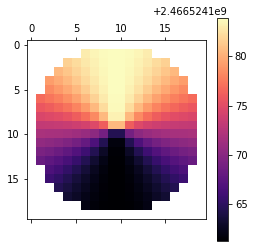

In [18]:
plt.matshow(ps,cmap='magma')
plt.colorbar()
wave_ttl

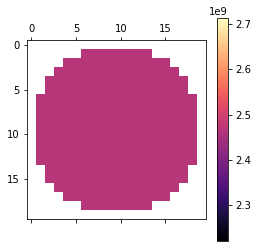

In [19]:
ps00 = wfe.zern(0,0,zmn=zmn,thmn=thmn,offset=offset)
plt.matshow(ps00,cmap='magma')
plt.colorbar()

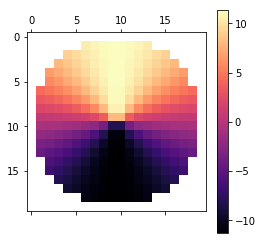

In [20]:
ps11 = wfe.zern(1,1,zmn=zmn,thmn=thmn,offset=offset)
plt.matshow(ps11,cmap='magma')
plt.colorbar()

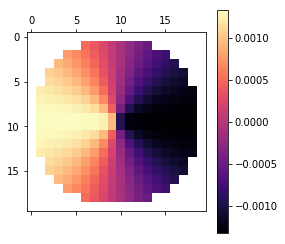

In [21]:
psm11 = wfe.zern(-1,1,zmn=zmn,thmn=thmn,offset=offset)
plt.matshow(psm11,cmap='magma')
plt.colorbar()

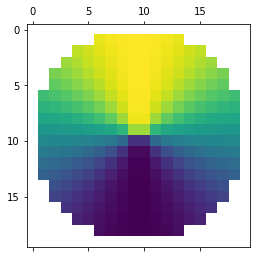

In [22]:
plt.matshow(ps11+psm11)

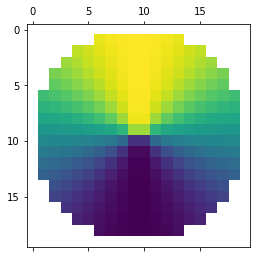

In [23]:
plt.matshow(ps00+ps11+psm11)

In [24]:
def plot_vec(v,offset=False):
    if offset==False:
        offset = [0,0]
    plt.plot([offset[0],v[0]],[offset[0],v[i]])
    plt.axis('equal')
    plt.show()

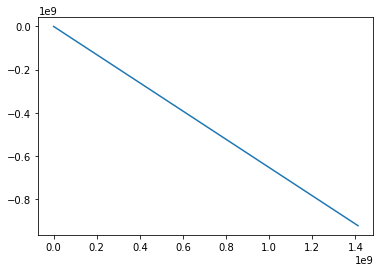

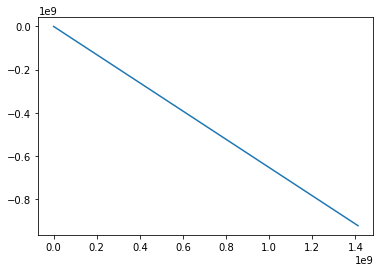

In [25]:
plot_vec(tele_beam)
plot_vec(beam)

In [26]:
np.linalg.norm(pos_rec-pos_send+tele_rel - beam)

2030.134007096879

In [27]:
LA.beam_coor(beam)

TypeError: beam_coor() takes exactly 4 arguments (2 given)

In [ ]:
np.linalg.norm(O_tele)

In [ ]:
tele_xoff

In [ ]:
tele_yoff

In [ ]:
O_tele

In [ ]:
np.linalg.norm(LA.unit(tele_rec)*L_tele)

In [ ]:

        
    ang_x = 0
    ang_y = 0
    [ang_x,ang_y] = LA.beam_ang(beam,tele_rec,n)

In [ ]:
#...adjust ps_send